# Load the basic packages for Keras and tensorflow.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import cv2
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

Using TensorFlow backend.


In [18]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Function to plot the samples:

In [2]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()



# function to load the .png images and convert to arrays:

In [3]:
import random
def load_images(directory):  
    arr = []
    for name in os.listdir(directory):
        filename = directory + '/' + name
        image = cv2.imread(filename,0)
        image_size = image.shape[1]
        original_dim = image_size * image_size
        image = np.reshape(image, [-1, original_dim])
        image = image.astype('float32') / 255
        arr.append(image)
    return arr

In [10]:
directory = 'ww_plots/'

if not os.path.isfile('*_pre-processed.npz'):
    x = load_images(directory)
    x = np.concatenate(x)
    np.savez("x_{}_bw_{}_pre-processed".format(directory.split('_')[0],x.shape[1]), x)
else:
    x_npz = np.load("x_{}_bw_{}_pre-processed.npz".format(directory.split('_')[0],x.shape[1]))
    x = x_npz['arr_0']    

In [11]:
#check the dimension of the loaded array:
x.shape

(49993, 50176)

# Split the array into 80% training and 20% test:

In [12]:
import random 
random.shuffle(x)

x_train = x[:int(len(x)*0.8)]
x_test = x[int(len(x)*0.8):]


In [13]:
original_dim = x.shape[1]

In [14]:
original_dim

50176

In [15]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 100

In [16]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

In [19]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])


In [20]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 50176)        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          25690624    encoder_input[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          131328      dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128)          32896       dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

In [21]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(64, activation='relu')(latent_inputs)
x = Dense(128, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(intermediate_dim, activation='relu')(x)
outputs = Dense(original_dim, activation='sigmoid')(x)

In [22]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_8 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_9 (Dense)              (None, 50176)             25740288  
Total params: 25,913,408
Trainable params: 25,913,408
Non-trainable params: 0
________________________________________________________________

In [23]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [24]:
#reconstruction_loss = mse(inputs, outputs)
reconstruction_loss = binary_crossentropy(inputs,outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 50176)             0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 25863364  
_________________________________________________________________
decoder (Model)              (None, 50176)             25913408  
Total params: 51,776,772
Trainable params: 51,776,772
Non-trainable params: 0
_________________________________________________________________


In [25]:
# train the autoencoder
vae.fit(x_train,epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, None))

Train on 39994 samples, validate on 9999 samples
Epoch 1/100
39994/39994 [==============================] - 28s 697us/step - loss: 10908.8058 - val_loss: 9743.0709
Epoch 2/100
39994/39994 [==============================] - 21s 523us/step - loss: 9695.0426 - val_loss: 9611.5221
Epoch 3/100
39994/39994 [==============================] - 21s 529us/step - loss: 9595.5722 - val_loss: 9565.6184
Epoch 4/100
39994/39994 [==============================] - 21s 535us/step - loss: 9560.2027 - val_loss: 9532.8899
Epoch 5/100
39994/39994 [==============================] - 22s 539us/step - loss: 9543.7874 - val_loss: 9514.9364
Epoch 6/100
39994/39994 [==============================] - 22s 542us/step - loss: 9516.2347 - val_loss: 9504.1467
Epoch 7/100
39994/39994 [==============================] - 22s 547us/step - loss: 9504.4818 - val_loss: 9503.6865
Epoch 8/100
39994/39994 [==============================] - 22s 548us/step - loss: 9486.9354 - val_loss: 9477.7111
Epoch 9/100
39994/39994 [=============

39994/39994 [==============================] - 21s 522us/step - loss: 8863.4543 - val_loss: 9381.8169
Epoch 72/100
39994/39994 [==============================] - 21s 521us/step - loss: 8833.4791 - val_loss: 9393.5402
Epoch 73/100
39994/39994 [==============================] - 21s 521us/step - loss: 8837.8207 - val_loss: 9404.0426
Epoch 74/100
39994/39994 [==============================] - 21s 528us/step - loss: 8838.2462 - val_loss: 9421.6169
Epoch 75/100
39994/39994 [==============================] - 21s 535us/step - loss: 8820.1215 - val_loss: 9400.6852
Epoch 76/100
39994/39994 [==============================] - 21s 533us/step - loss: 8839.6442 - val_loss: 9408.5813
Epoch 77/100
39994/39994 [==============================] - 21s 534us/step - loss: 8818.4949 - val_loss: 9410.1471
Epoch 78/100
39994/39994 [==============================] - 21s 535us/step - loss: 8890.2422 - val_loss: 9431.5047
Epoch 79/100
39994/39994 [==============================] - 21s 533us/step - loss: 8864.3006 

In [26]:
# check what the features the encoder is learning:
z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)

In [27]:
# this function defines a way to combine features 2 by 2, 
# to be used for plot samples from different latent dimensions
from itertools import combinations
from matplotlib.backends.backend_pdf import PdfPages

def rSubset(arr,k):
    return list(combinations(arr,k))

at = rSubset(range(latent_dim),2)

In [31]:
# cerate a pdf with all the combination of samples from latent dimension
with PdfPages('Plots_of_latent_space_dim_{}.pdf'.format(latent_dim)) as pdf:
    for i,j in at:
        plt.figure(figsize=(12,10))
        plt.scatter(z_mean[:, i], z_mean[:, j],label='$Z[{}],Z[{}]$'.format(i,j))
        plt.legend(loc='best')    
        plt.xlabel("z[{}]".format(i))
        plt.ylabel("z[{}]".format(j))
        plt.grid()
        pdf.savefig()
        plt.close()

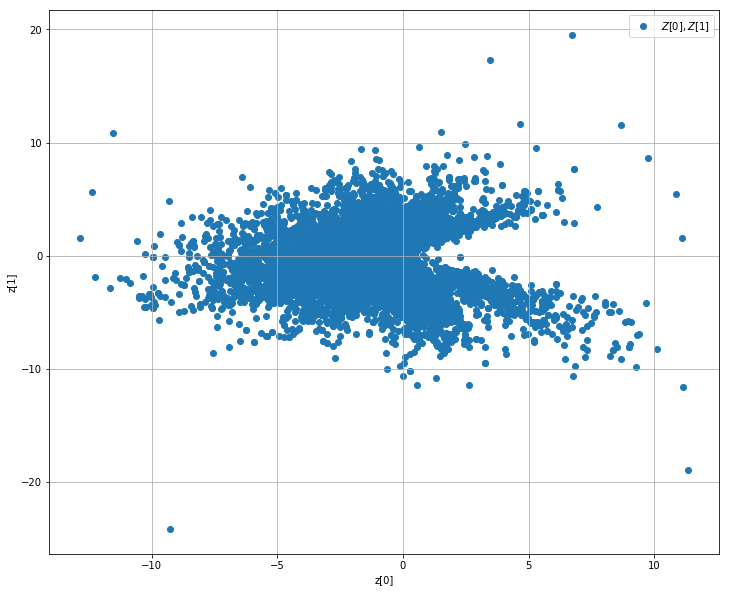

In [32]:
plt.figure(figsize=(12,10))
#for i, j in list(combinations(range(4),2)):
#    plt.scatter(z_mean[:, i], z_mean[:, j],label='$Z[{}],Z[{}]$'.format(i,j))
plt.scatter(z_mean[:,0], z_mean[:, 1],label='$Z[{}],Z[{}]$'.format(0,1))
plt.legend(loc='best')    
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.grid()
#plt.savefig('latent_2dim_ww_tt.pdf')
plt.show()

In [33]:
# display a 5x5 2D manifold of digits
n = 5
digit_size = 224
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(z_mean[:,0].min(), z_mean[:,0].max(), n)
grid_y = np.linspace(z_mean[:,1].min(), z_mean[:,1].max(), n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi,yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

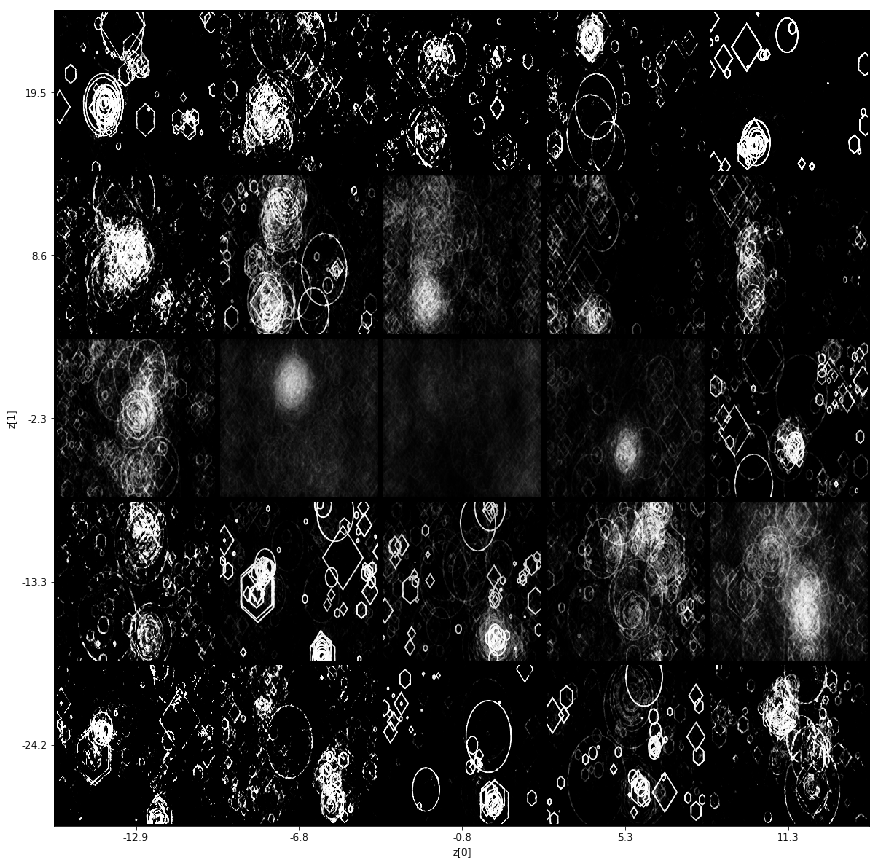

In [34]:
#visualization of the latent dimension samples
plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='Greys_r')
#plt.savefig('Plots_of_manifolds_dim_2_ww_tt.pdf')
plt.show()

In [38]:
#select one sample for Z[0] and Z[1]
z_sample = np.array([[-6.8,-13.3]])
x_decoded = decoder.predict(z_sample)


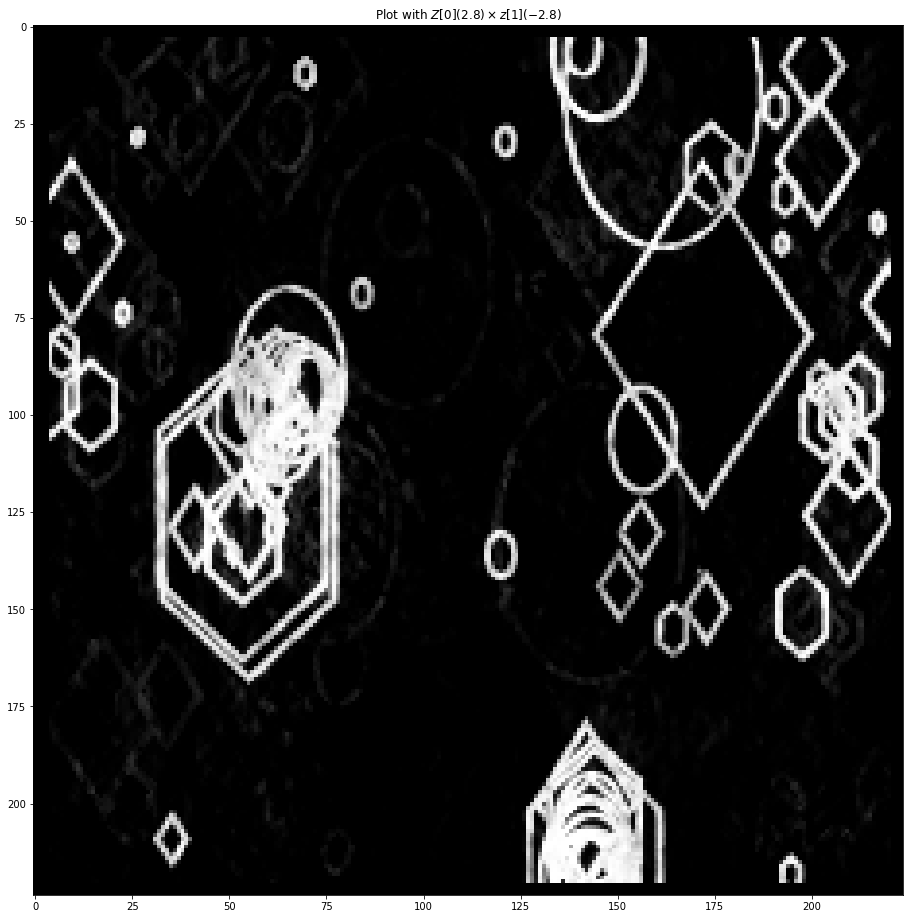

In [39]:
plt.figure(figsize=(16,16))
plt.subplot(111)
plt.imshow(x_decoded.reshape(224,224))
plt.title('Plot with $Z[0]({})\\times z[1]({})$'.format(2.8,-2.8))
plt.gray()
plt.savefig('selected_manifolds_dim_2_ww.pdf')
plt.show()

# A little more sofisticated plot for the latent dimension sampling:

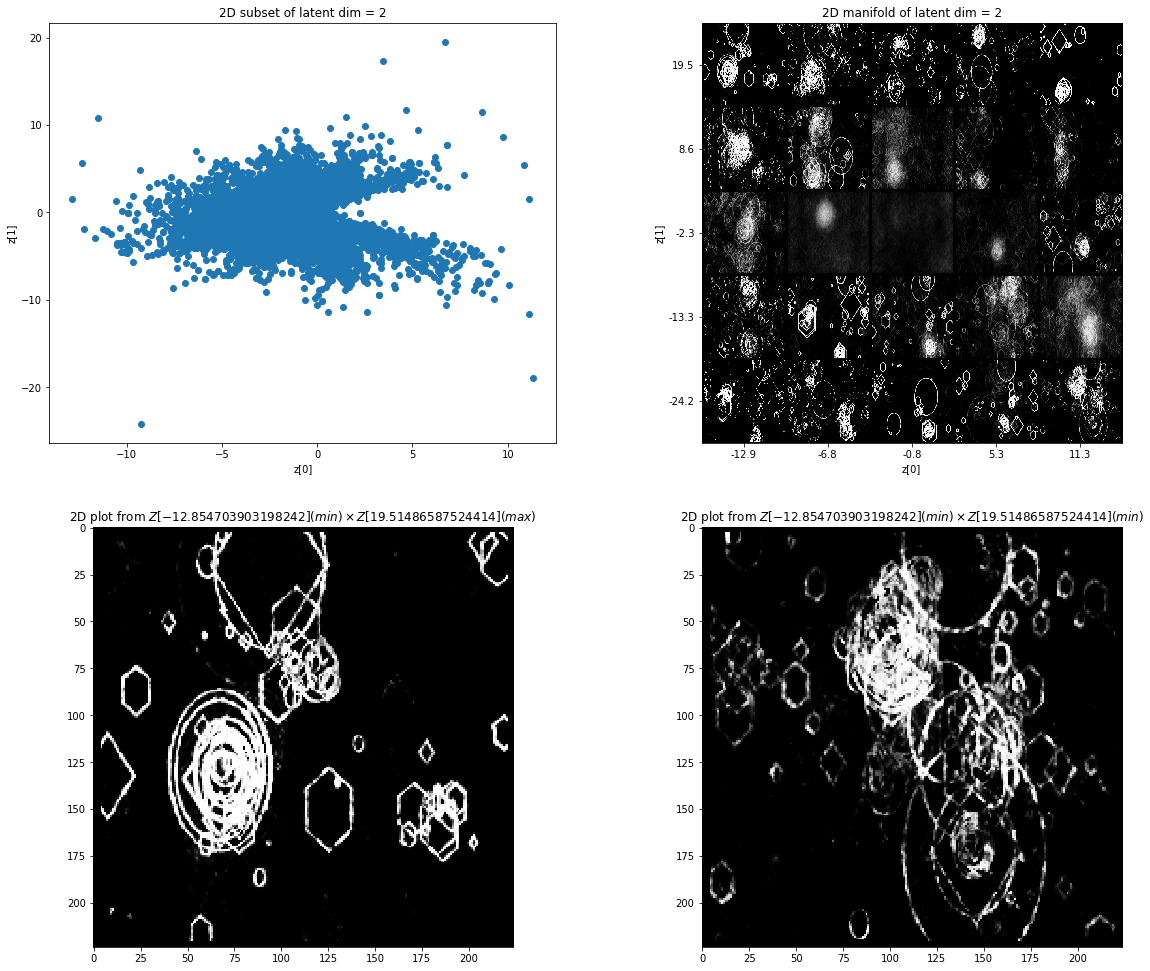

In [41]:
plt.figure(figsize=(20,17))
ax1 = plt.subplot(221)
scatter = ax1.scatter(z_mean[:, 0], z_mean[:, 1])
plt.xlabel("z[0]")
plt.ylabel("z[1]")
ax1.set_title('2D subset of latent dim = {}'.format(latent_dim))

n = 5
digit_size = 224
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(z_mean[:,0].min(), z_mean[:,0].max(), n)
grid_y = np.linspace(z_mean[:,1].min(), z_mean[:,1].max(), n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[x for x in np.linspace(xi,yi,latent_dim)]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

ax2 = plt.subplot(222)        
start_range = digit_size // 2
end_range = n * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
ax2.imshow(figure, cmap='Greys_r')
ax2.set_title('2D manifold of latent dim = {}'.format(latent_dim))

ax3 = plt.subplot(223)
z_sample_tl = np.array([[x for x in np.linspace(z_mean[:,0].min(), z_mean[:,1].max(),latent_dim)]])
x_decoded_tl = decoder.predict(z_sample_tl)
ax3.imshow(x_decoded_tl.reshape(224,224),cmap='Greys_r')
ax3.set_title('2D plot from $Z[{}](min)\\times Z[{}](max)$'.format(z_mean[:,0].min(), z_mean[:,1].max()))

ax4 = plt.subplot(224)
z_sample_br = np.array([[x for x in np.linspace(z_mean[:,0].max(), z_mean[:,1].min(),latent_dim)]])
x_decoded_br = decoder.predict(z_sample_br)
ax4.imshow(x_decoded_br.reshape(224,224),cmap='Greys_r')
ax4.set_title('2D plot from $Z[{}](min)\\times Z[{}](min)$'.format(z_mean[:,0].min(), z_mean[:,1].max()))

plt.savefig('Plots_all_dim_2_ww.pdf')
plt.show()        

In [42]:
def fancy_plost(latent_mean,x_dim,y_dim,lat_dim):
    ### plot the scatterplots for the combination of latent space
    plt.figure(figsize=(20,17))
    ax1 = plt.subplot(221)
    scatter = ax1.scatter(latent_mean[:, x_dim], latent_mean[:, y_dim])
    plt.xlabel("z[{}]".format(x_dim))
    plt.ylabel("z[{}]".format(y_dim))
    plt.grid()
    ax1.set_title('2D subset of latent dim = {}'.format(lat_dim))
    
    ### plot 2D manifold for latent_dim
    n = 5
    digit_size = 224
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(latent_mean[:,x_dim].min(), latent_mean[:,x_dim].max(), n)
    grid_y = np.linspace(latent_mean[:,y_dim].min(), latent_mean[:,y_dim].max(), n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[x for x in np.linspace(xi,yi,lat_dim)]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

    ax2 = plt.subplot(222)        
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[{}]".format(x_dim))
    plt.ylabel("z[{}]".format(y_dim))
    ax2.imshow(figure, cmap='Greys_r')
    ax2.set_title('2D manifold of latent dim = {}'.format(lat_dim))

    ###plot of x_min and y_max
    ax3 = plt.subplot(223)
    z_sample_tl = np.array([[x for x in np.linspace(latent_mean[:,x_dim].min(), latent_mean[:,y_dim].max(),lat_dim)]])
    x_decoded_tl = decoder.predict(z_sample_tl)
    ax3.imshow(x_decoded_tl.reshape(224,224), cmap='Greys_r')
    ax3.set_title('2D plot from $Z[{}](min)\\times Z[{}](max)$'.format(x_dim,y_dim))
    
    ###plot of x_max and y_min
    ax4 = plt.subplot(224)
    z_sample_br = np.array([[x for x in np.linspace(latent_mean[:,x_dim].min(), latent_mean[:,y_dim].min(),lat_dim)]])
    x_decoded_br = decoder.predict(z_sample_br)
    ax4.imshow(x_decoded_br.reshape(224,224), cmap='Greys_r')
    ax4.set_title('2D plot from $Z[{}](min)\\times Z[{}](min)$'.format(x_dim,y_dim))

#    plt.show()        

In [43]:
at = rSubset(range(latent_dim),2)
with PdfPages('Plots_of_manifolds_dim_{}.pdf'.format(latent_dim)) as pdf:
    for i,j in at:
        fancy_plost(z_mean,i,j,latent_dim)
        pdf.savefig()
        plt.close()